# Common Pool Resource with Single Agent

In [1]:
using MultiAgentEmergence
using POMDPs
using POMDPPolicies
using POMDPSimulators
using POMDPModelTools
using Reel, Printf
using Cairo, Fontconfig, Plots

┌ Info: Precompiling MultiAgentEmergence [6efdc3e2-65f5-49e0-b0e5-5cf75fc7274f]
└ @ Base loading.jl:1342
┌ Warning: Error requiring `UnicodePlots` from `Plots`
│   exception = (LoadError("/Users/liamsmith/.julia/packages/Plots/5kcBO/src/backends/unicodeplots.jl", 77, UndefVarError(:UserColorType)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00000001011f42cf, Ptr{Nothing} @0x00000001012882a1, Ptr{Nothing} @0x0000000107716d52, Ptr{Nothing} @0x0000000101272fbf, Ptr{Nothing} @0x000000010128a25f, Ptr{Nothing} @0x0000000101288b94, Ptr{Nothing} @0x0000000101288f0c, Base.InterpreterIP in top-level CodeInfo for Plots at statement 3, Ptr{Nothing} @0x00000001012a3844, Ptr{Nothing} @0x00000001012a3604, Ptr{Nothing} @0x00000001012a4134, Ptr{Nothing} @0x0000000107adf4e7, Ptr{Nothing} @0x0000000101272fbf, Ptr{Nothing} @0x0000000107b30312, Ptr{Nothing} @0x0000000107766a65, Ptr{Nothing} @0x0000000101272fbf, Ptr{Nothing} @0x000000010127f839, Ptr{Nothing} @0x000000010622e08e, Ptr{Nothing} @0

In [2]:
# Global Settings
hr = HistoryRecorder(max_steps = 1000)
pomdp = CommonPool()
POMDPs.observation(s::CommonPoolState) = POMDPs.observation(pomdp, s)
map = DefaultMap(pomdp)
POMDPs.initialstate_distribution(m::CommonPool) = Deterministic(map)

episodes = 50

50

## Visualization

In [3]:
# Display Gif 
function display_gif(h::SimHistory)
    for (s, a, sp) in eachstep(h)
    IJulia.clear_output(true)
    display(render(pomdp, (s=sp,a=a)))
    sleep(1/60) # 60 fps
    end
end

# Save Gif
function save_gif(h::SimHistory,fname::String)
    frames = Frames(MIME("image/png"), fps=30)
    for (s, a, sp) in eachstep(h)
        push!(frames,render(pomdp, (s=sp,a=a)))
    end
    str = @sprintf("%s.gif",fname)
    write(str, frames)
end

# Save Socials
function save_socials(h_array::Vector{Any},fname::String)
    str = @sprintf("%s.png",fname)
    savefig(plot_socials(h_array),fname)
end

# Display Combined Socials
function plot_socials_combo()
    p1 = plot_socials(harray_random)       # blue
    p2 = plot_socials!(p1, harray_greedy)  # red
    p3 = plot_socials!(p2, harray_path)    # green
    p4 = plot_socials!(p3, harray_dqn)     # purple
    display(p4)
end

# Save Combined Socials
function save_socials_combo()
    str = @sprintf("%s.png","combo")
    p1 = plot_socials(harray_random)       # blue
    p2 = plot_socials!(p1, harray_greedy)  # red
    p3 = plot_socials!(p2, harray_path)    # green
    p4 = plot_socials!(p3, harray_dqn)     # purple
    savefig(p4,str)
end

save_socials_combo (generic function with 1 method)

## Random Policy
Move in random direction

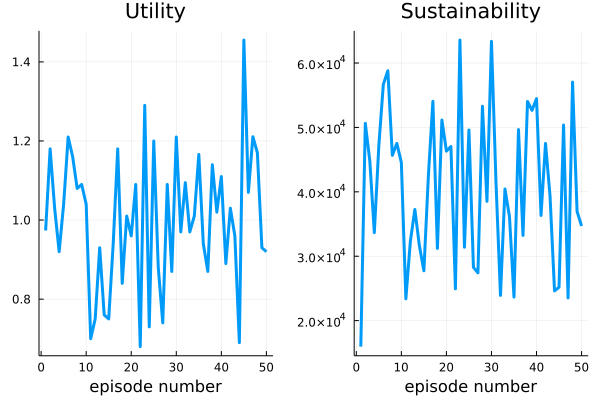

In [9]:
fname = "random"
policy_random = random_policy
harray_random = []
for i in 1:episodes 
    push!(harray_random, simulate(hr, pomdp, policy_random))
end
save_socials(harray_random,fname)
plot_socials(harray_random)

In [10]:
# Gif of one episode
fname = "random"
ep_num = rand(1:length(harray_random))
h = harray_random[ep_num]
#display_gif(h)
save_gif(h,fname)

"random.gif"

## Greedy Policy
Move in direction of most resources (observation range radius: 3)

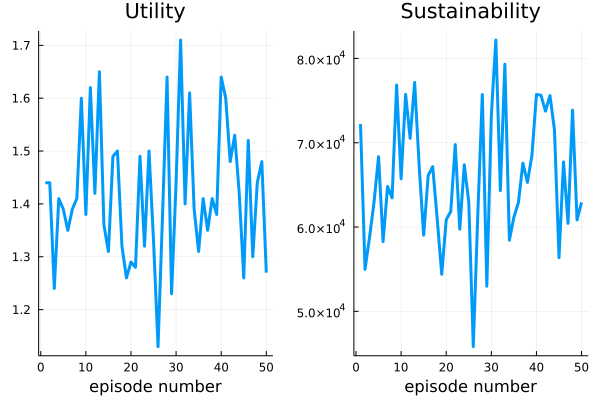

In [11]:
fname = "greedy"
obs_range = 3
POMDPs.observation(m::CommonPool, s::CommonPoolState) = POMDPs.observation(m, s, obs_range)
POMDPs.observation(s::CommonPoolState) = POMDPs.observation(pomdp, s, obs_range)

policy_greedy = greedy_policy
harray_greedy = []
for i in 1:episodes 
    push!(harray_greedy, simulate(hr, pomdp, policy_greedy))
end
save_socials(harray_greedy,fname)
plot_socials(harray_greedy)

In [12]:
# Gif of one episode
fname = "greedy"
ep_num = rand(1:length(harray_greedy))
h = harray_greedy[ep_num]
#display_gif(h)
save_gif(h,fname)

"greedy.gif"

## Path Policy
Follow predefined path

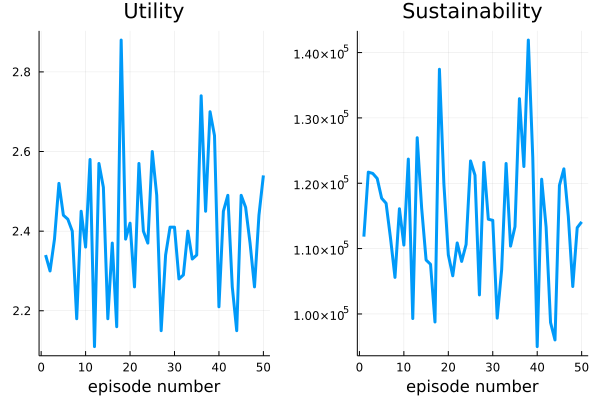

In [13]:
fname = "path"
policy_path = path_policy(pomdp,map)
harray_path = []
for i in 1:episodes 
    push!(harray_path, simulate(hr, pomdp, policy_path))
    policy_path = path_policy(pomdp,map) # reset the path each iteration
end
save_socials(harray_path,fname)
plot_socials(harray_path)

In [14]:
# Gif of one episode
fname = "path"
ep_num = rand(1:length(harray_path))
h = harray_path[ep_num]
#display_gif(h)
save_gif(h,fname)

"path.gif"

## DQN Policy

In [4]:
using DeepQLearning
using Flux

In [ ]:
fname = "dqn"
obs_range = 4
POMDPs.observation(m::CommonPool, s::CommonPoolState) = POMDPs.observation(m, s, obs_range)
POMDPs.initialobs(m::CommonPool, s::CommonPoolState) = POMDPs.observation(m, s, obs_range)

#DQN
n_hidden = 100
layer1 = Dense((2*obs_range+1)^2, n_hidden, leakyrelu)
layer2 = Dense(n_hidden,n_hidden,leakyrelu)
layer3 = Dense(n_hidden, length(actions(pomdp)))
model  = Chain(layer1, layer2, layer3)

steps = 50000
exploration = EpsGreedyPolicy(pomdp, LinearDecaySchedule(start=1.0, stop=0.01, steps=steps/4))

solver = DeepQLearningSolver(qnetwork = model, max_steps=steps, 
                             exploration_policy = exploration,
                             learning_rate=0.01,log_freq=1000,
                             recurrence=false,double_q=true, dueling=true, prioritized_replay=true)

policy_dqn = solve(solver, pomdp)

Evaluation ... Avg Reward 77.90 | Avg Step 101.00 
 1000 / 50000 eps 0.921 |  avgR 138.182 | Loss 2.105e+00 | Grad 7.716e-01 | EvalR 77.900 
Evaluation ... Avg Reward 135.80 | Avg Step 101.00 
Evaluation ... Avg Reward 94.70 | Avg Step 101.00 
 2000 / 50000 eps 0.842 |  avgR 155.714 | Loss 4.690e+00 | Grad 6.477e+00 | EvalR 94.700 
Evaluation ... Avg Reward 57.40 | Avg Step 101.00 
Evaluation ... Avg Reward 88.50 | Avg Step 101.00 
 3000 / 50000 eps 0.762 |  avgR 161.613 | Loss 2.882e+00 | Grad 7.905e+00 | EvalR 88.500 
Evaluation ... Avg Reward 81.30 | Avg Step 101.00 
Saving new model with eval reward 81.300 
Evaluation ... Avg Reward 69.20 | Avg Step 101.00 
 4000 / 50000 eps 0.683 |  avgR 171.463 | Loss 4.707e+00 | Grad 8.253e+00 | EvalR 69.200 
Evaluation ... Avg Reward 79.10 | Avg Step 101.00 
Evaluation ... Avg Reward 83.50 | Avg Step 101.00 
 5000 / 50000 eps 0.604 |  avgR 178.431 | Loss 3.306e+00 | Grad 7.564e+00 | EvalR 83.500 
Evaluation ... Avg Reward 157.10 | Avg Step 101.

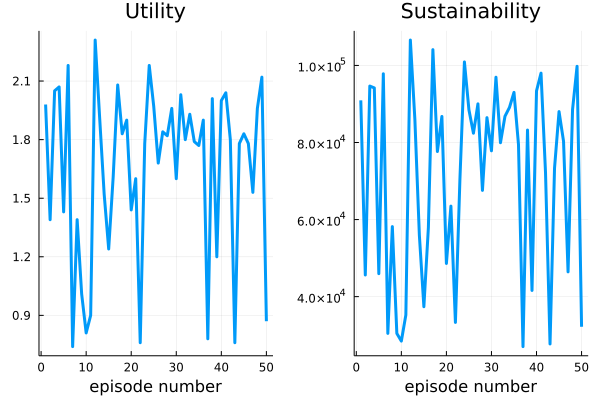

In [6]:
fname = "dqn"
harray_dqn = []
for i in 1:episodes 
    push!(harray_dqn, simulate(hr, pomdp, policy_dqn))
end
save_socials(harray_dqn,fname)
plot_socials(harray_dqn)

In [21]:
# Gif of one episode
fname = "dqn"
ep_num = rand(1:length(harray_dqn))
h = harray_dqn[49]
#display_gif(h)
save_gif(h,fname)

"dqn.gif"

In [18]:
# Save Model
using BSON: @save
@save "DQN_SingleAgent_model.bson" model

## Compare Policies

In [ ]:
p1 = plot_socials(harray_random)       # blue
p2 = plot_socials!(p1, harray_greedy)  # red
p3 = plot_socials!(p2, harray_path)    # green
p4 = plot_socials!(p3, harray_dqn)     # purple

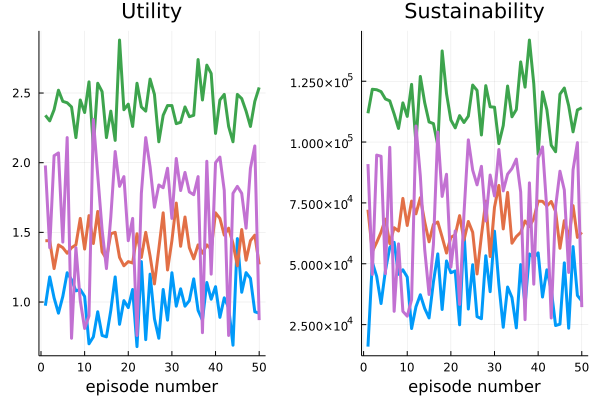

In [15]:
plot_socials_combo()

In [16]:
save_socials_combo()